## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

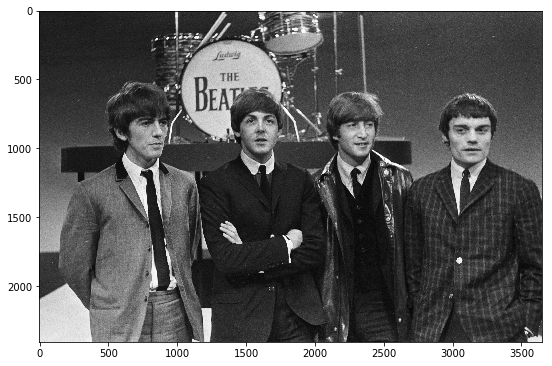

In [10]:
import cv2
# load in color image for face detection
image = cv2.imread('images/the_beatles.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


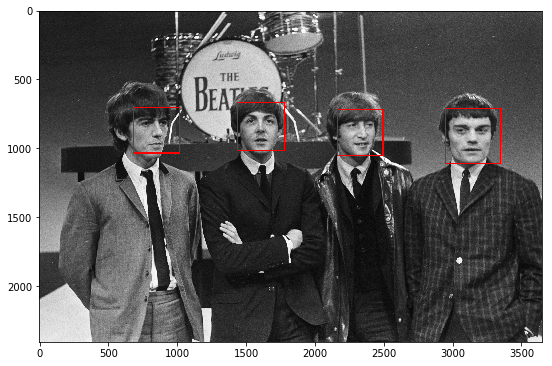

In [11]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.3, 5) # this parameters works best for selected images

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),8) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [12]:
# Extra Function for loading images from a given path
def imgLoader(path="", specyfic_images = []):
    """ """
    images = []
    
    if len(specyfic_images) > 0:
        for name in specyfic_images:
            try:
                image = cv2.imread(os.path.join(path, name))
                images.append(image)
            except:
                print("Failed to Load: {}".format(name))  
                
    else:
        for file in os.listdir(path):
            if file.endswith(".jpg") or file.endswith(".png"):
                try:
                    image = cv2.imread(os.path.join(path, file))
                    images.append(image)
                except:
                    print("Failed to Load: {}".format(file))  
            else:
                continue
            
    return images

In [13]:
all_images = imgLoader("images", ["the_beatles.jpg", "mona_lisa.jpg", "obamas.jpg", "friends.jpg"])
print("Loaded {} images".format(len(all_images)))

Loaded 4 images


In [14]:
#Extract Faces from all of the loaded images:

# Add perc padding to detected face for better keypoint detection and visualisation
# Note: no assert with the ROI selection please be careful with faces around the photo edges
perc = 30
all_faces = []

for i, image in enumerate(all_images):
    faces = face_cascade.detectMultiScale(image, 1.3, 5) # this parameters works best for selected images
    
    for (x,y,w,h) in faces:
        # Select the region of interest that is the face in the image 
        pxh = int((perc/100)*h)
        pxw = int((perc/100)*w)
        roi = image[y-int(pxh/2):y+h+int(pxh/2), x-int(pxw/2):x+w+int(pxw/2)]
        all_faces.append(roi)
    

print("Extracted {} faces from {} images".format(len(all_faces), len(all_images)))


Extracted 13 faces from 4 images


## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [15]:
import torch
from models import KeyPointNetCNN as Net

net = Net()

## load the best saved model parameters (by your path name)
net.load_state_dict(torch.load('saved_models/KeyPointNetCNN_Epoch_199_200425_174037.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

KeyPointNetCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_bn): BatchNorm1d(6528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_bn): BatchNorm1d(1088, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16224, out_features=6528, bias=True)
  (fc2): Linear(in_features=6528, out_features=1088, bias=True)
  (fc3): Linear(in_features=1088, out_features=1

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested) (250x250) used in the created network
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [16]:
class TransformFace:
    """ Transform face images according to a given configuration
        Future improvement: Use PyTorch data loader"""

    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def _toGray(self):
        """Convert to Gray"""
        new_images = []
        for image in self.images:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            new_images.append(image)
        self.images = new_images
            
    def _rescale(self):
        """Rescale to a given size"""
        new_images = []
        for image in self.images:
            image = cv2.resize(image, (self.transform["Size"][0], self.transform["Size"][1]))
            new_images.append(image)
        self.images = new_images
            
            
    def _normalise(self):
        """Convert from 0-255 to 0.0-1.0 image"""
        new_images = []
        for image in self.images:
            image = image/255.0
            new_images.append(image)
        self.images = new_images
            
    def _toTensor(self):
        """Convert each image to a PyTorch  tensor"""
        new_images = []
        for image in self.images:
            if(len(image.shape) == 2):
                image = image.reshape(image.shape[0], image.shape[1], 1)
            image = image.transpose((2, 0, 1))
            new_images.append(image)
        self.images = new_images
            
    def imgTransform(self):
        """Perform Image Transformation"""
        if self.transform["Gray"]:
            self._toGray()
        if len(self.transform["Size"]) == 2:
            self._rescale()
        if self.transform["Normalise"]:
            self._normalise()
        if self.transform["ToTensor"]:
            self._toTensor()
            
    def getTransformed(self):
        """Get transformed images in a format of a python list containing PyTorch tensors"""
        self.imgTransform()
        return self.images


In [17]:
# Functions to plot the images and the detected key points - from Notebook 2:
import math

def show_all_keypoints(ax, image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    ax.imshow(image, cmap='gray')
    ax.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='r')
    # plot ground truth points as green pts
    if gt_pts is not None:
        ax.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='r')
        
        
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    """Visualise the output:"""
    
    fig = plt.figure(figsize=(20,7))
    for i in range(batch_size):
        ax = fig.add_subplot(2, math.ceil(batch_size/2), i+1)

        # un-transform the image data
        image = test_images[i].data              # get the image from it's wrapper        
        image = image.numpy()                    # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(ax, np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

In [20]:
# Create Image transform configuration:
image_config = {"Size": (255, 255),
                "Gray": True,
                "Normalise": True,
                "ToTensor": True}

# Process the face images
transformer = TransformFace(all_faces, transform=image_config)
transformed_images = transformer.getTransformed()

print("Type: {} of len {}".format(type(transformed_images), len(transformed_images)))
print("Shape:", transformed_images[0].shape)

Type: <class 'list'> of len 13
Shape: (1, 255, 255)


In [21]:
enableGPU = False

# Utilise GPU if available:
if  enableGPU and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    print('Using GPU:',torch.cuda.get_device_name())
else:
    dtype = torch.FloatTensor
    print('Using CPU ...')

Using CPU ...


In [22]:
# Transform images list to a PyTorch tensor to be compatible with the network input:
tensor_images = torch.FloatTensor(transformed_images)

# Get Network Facial keypoint predictions:
output_pts = net(tensor_images)

# Reshape Keypoints so it is posible to plot
output_pts = output_pts.view(output_pts.size()[0], 68, -1)

print(type(tensor_images), tensor_images.shape)
print(type(output_pts), output_pts.shape)

<class 'torch.Tensor'> torch.Size([13, 1, 255, 255])
<class 'torch.Tensor'> torch.Size([13, 68, 2])


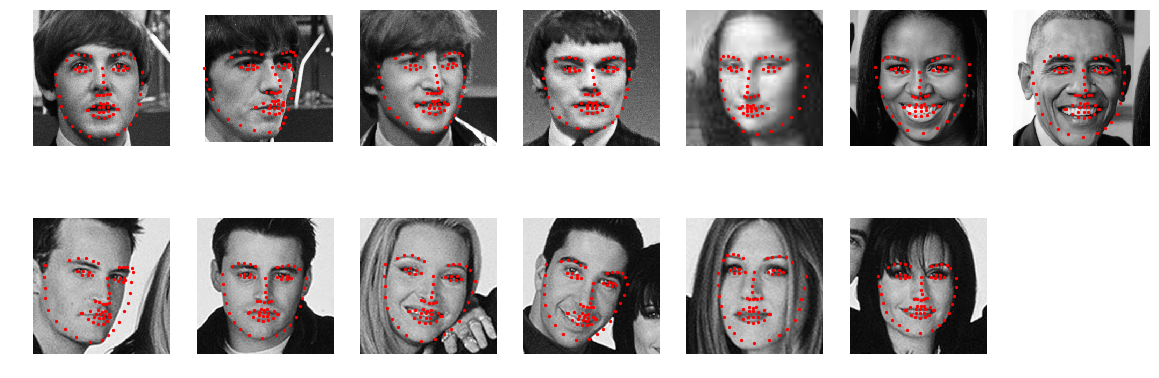

In [23]:
# Plot the extracted faces with the key points overlay.
visualize_output(tensor_images, output_pts, batch_size=13)